In [120]:
import requests
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode()
import cmocean
import matplotlib.pylab as plt
from scipy.interpolate import griddata
from datetime import datetime
import pdb
import os

# depreciated but still usefull.
from mpl_toolkits.basemap import Basemap

#used for map projections
from netCDF4 import Dataset as netcdf_dataset
from cartopy import config
import cartopy.crs as ccrs

%matplotlib inline

#sets plot styles
import seaborn as sns
from matplotlib import rc
from matplotlib import rcParams
import matplotlib.ticker as mtick
rc('text', usetex=False)
rcStyle = {"font.size":20,
           "legend.fontsize":12,
           "axes.titlesize":28,
           "axes.labelsize":20,
           'xtick.labelsize':16,
           'ytick.labelsize':16}
sns.set_context("paper", rc=rcStyle)
sns.set_style("whitegrid", {'axes.grid' : False})
myColors = ["windows blue", "amber", "dusty rose", "prussian blue", "faded green", "dusty purple", "gold", "dark pink"]
colorsBW = ["black", "grey"]
sns.set_palette(sns.xkcd_palette(myColors))

figurePath = '~/Desktop/OSU/pyFig/'

In [5]:
def get_profile(profile_number):
    resp = requests.get('http://www.argovis.com/catalog/profiles/'+profile_number)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    profile = resp.json()
    return profile
def get_platform_profiles(platform_number):
    resp = requests.get('http://www.argovis.com/catalog/platforms/'+platform_number)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    platformProfiles = resp.json()
    return platformProfiles

def parse_into_df(profiles):
    #initialize dict
    meas_keys = profiles[0]['measurements'][0].keys()
    df = pd.DataFrame(columns=meas_keys)
    for profile in profiles:
        profileDf = pd.DataFrame(profile['measurements'])
        profileDf['cycle_number'] = profile['cycle_number']
        profileDf['profile_id'] = profile['_id']
        profileDf['lat'] = profile['lat']
        profileDf['lon'] = profile['lon']
        profileDf['date'] = profile['date']
        df = pd.concat([df, profileDf])
    return df

In [6]:
def get_selection_profiles(startDate, endDate, shape, presRange=None):
    baseURL = 'http://www.argovis.com/selection/profiles'
    startDateQuery = '?startDate=' + startDate
    endDateQuery = '&endDate=' + endDate
    shapeQuery = '&shape='+shape
    if not presRange == None:
        pressRangeQuery = '&presRange=' + presRange
        url = baseURL + startDateQuery + endDateQuery + pressRangeQuery + shapeQuery
    else:
        url = baseURL + startDateQuery + endDateQuery + shapeQuery
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    selectionProfiles = resp.json()
    return selectionProfiles


startDate='2017-9-15'
endDate='2017-10-31'
# shape should be nested array with lon, lat coords.
shape = '[[[-18.6,31.7],[-18.6,37.7],[-5.9,37.7],[-5.9,31.7],[-18.6,31.7]]]'
presRange='[0,30]'

In [20]:
def get_monthly_profile_pos(month, year):
    #baseURL = 'http://localhost:3000/selection/profiles'
    baseURL = 'http://argovis.com/selection/profiles'
    url = baseURL + '/' + str(month) + '/' + str(year)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    monthlyProfilePos = resp.json()
    return monthlyProfilePos

def parse_pos_into_df(profiles):
    #initialize dict
    df = pd.DataFrame(profiles)
    if df.shape[0] == 0:
        return 'error: no dataframes'
    df['lon'] = df['geoLocation'].apply(lambda row: row['coordinates'][0])
    df['lat'] = df['geoLocation'].apply(lambda row: row['coordinates'][1])
    df.drop(['geoLocation'], axis=1, inplace=True)
    return df

def bin_pos_df(df, delta):
    to_bin = lambda x: np.floor(x / delta) * delta
    df["latbin"] = df.lat.map(to_bin)
    df["lonbin"] = df.lon.map(to_bin)
    df.set_index(['latbin', 'lonbin'], inplace=True)
    df['nProf'] = df['_id'].groupby(level=['latbin', 'lonbin']).count()
    return df

In [21]:
def bin_pos_df(df, delta=1):
    df = df[['_id', 'lat', 'lon']].copy()
    to_bin = lambda x: np.floor(x / delta) * delta
    df["latbin"] = df.lat.map(to_bin)
    df["lonbin"] = df.lon.map(to_bin)
    df.set_index(['latbin', 'lonbin'], inplace=True)
    df['nProf'] = df['_id'].groupby(level=['latbin', 'lonbin']).count()
    return df

In [22]:
#used for histogram

monthlyProfilePos = get_monthly_profile_pos(1, 2018)
monthlyDf = parse_pos_into_df(monthlyProfilePos)
binnedDf = bin_pos_df(monthlyDf, 1)
binnedDf.head()

_id       lat        lon  nProf
latbin lonbin                                         
-15.0  -93.0    3901815_52 -14.90588  -92.72271      1
-33.0  -48.0   5903605_153 -32.30200  -47.91400      4
 2.0    140.0  4901655_128   2.46600  140.68100      2
 17.0  -149.0  4902079_101  17.51000 -148.58600      3
 0.0   -136.0  5904501_207   0.34883 -135.38461      3

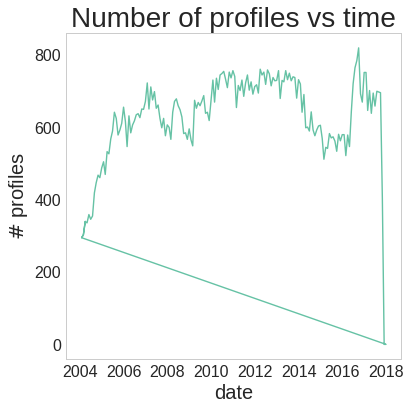

In [23]:
profTimeSeriesDf = pd.read_csv('profileTimeSeries.csv')
profTimeSeriesDf['date'] = pd.to_datetime(profTimeSeriesDf['date'])
myDR = pd.date_range('2004-01-01', '2018-01-01', periods=None, freq='M')
fig_size = (6,6)
plt.rcParams["figure.figsize"] = fig_size
figProf = plt.figure()
axes = plt.axes()
x = profTimeSeriesDf['date'].values
y = profTimeSeriesDf['nProf'].values
axes.plot(x, y)
axes.set_title('Number of profiles vs time')
axes.set_ylabel('$\#$ profiles')
axes.set_xlabel('date')
plt.show()

#profTimeSeriesDf['nProf'].plot()

Dataframes also have a group feature that can be used tally up by type, positioning system, dac, etc.

In [24]:
profTimeSeriesDf = pd.read_csv('groupedProfileTimeSeries.csv')
profTimeSeriesDf['date'] = pd.to_datetime(profTimeSeriesDf['date'])
profTimeSeriesDf.drop('Unnamed: 0', axis=1, inplace=True)

psTimeSeriesDf = pd.read_csv('groupedProfilePositioningSystemTimeSeries.csv')
psTimeSeriesDf['date'] = pd.to_datetime(psTimeSeriesDf['date'])
psTimeSeriesDf.drop('Unnamed: 0', axis=1, inplace=True)

typeTimeSeriesDf = pd.read_csv('groupedProfileTypeTimeSeries.csv')
typeTimeSeriesDf['date'] = pd.to_datetime(typeTimeSeriesDf['date'])
typeTimeSeriesDf.drop('Unnamed: 0', axis=1, inplace=True)

dacTimeSeriesDf = pd.read_csv('groupedDacTimeSeries.csv')
dacTimeSeriesDf['date'] = pd.to_datetime(dacTimeSeriesDf['date'])
dacTimeSeriesDf.drop('Unnamed: 0', axis=1, inplace=True)

In [25]:
def make_stack_plot(df, figsize=(15,4), title=True):
    dataDf = df.drop(['date', 'nProf'], axis=1)
    fig = plt.figure(figsize=figsize)
    axes = plt.axes()
    if title:
        axes.set_title('Number of profiles per month vs. time')
    axes.set_ylabel('# Profiles/month')
    axes.set_xlabel('Date')
    axes.stackplot(df['date'].values, dataDf.T, labels=dataDf.columns)
    axes.legend(loc=2)

#ax.stackplot(df['year'].values, df.drop('year',axis=1).T)

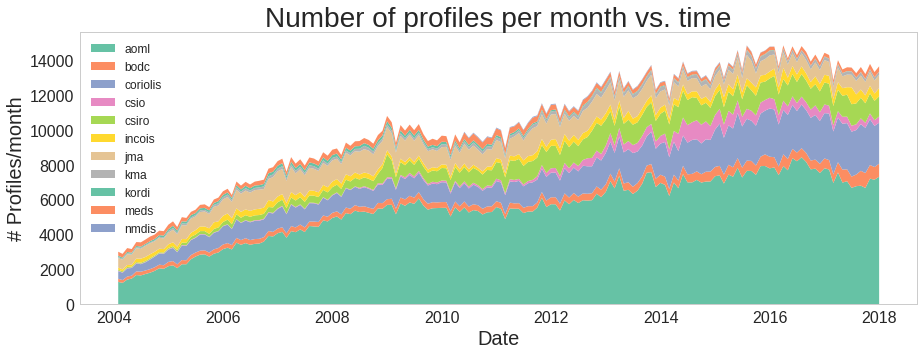

In [26]:
#sns.set_palette("husl")
sns.set_palette(sns.color_palette("Set2", 12))
make_stack_plot(dacTimeSeriesDf, figsize=(15,5), title=True)
plt.savefig('dacVsTime.png', dpi=200)

In [86]:
typeTimeSeriesDf.head()

Unnamed: 1  ALAMO  APEX  APEX Profiling Float  APEX-SBE  APEX_D  ARVOR  \
0         NaN    NaN  1479                   NaN     165.0     NaN    NaN   
1         NaN    NaN  1403                   NaN     158.0     NaN    NaN   
2         NaN    NaN  1542                   NaN     161.0     NaN    NaN   
3         NaN    NaN  1533                   NaN     152.0     NaN    NaN   
4         NaN    NaN  1814                   NaN     164.0     NaN    NaN   

   ARVOR_D  HM2000  NAVIS  ...    S2A  S2X  SOLO  SOLO-W  SOLO_D  SOLO_II  \
0      NaN     NaN    NaN  ...    NaN  NaN   296     NaN     NaN      NaN   
1      NaN     NaN    NaN  ...    NaN  NaN   300     NaN     NaN      NaN   
2      NaN     NaN    NaN  ...    NaN  NaN   400     NaN     NaN      NaN   
3      NaN     NaN    NaN  ...    NaN  NaN   407     NaN     NaN      NaN   
4      NaN     NaN    NaN  ...    NaN  NaN   463     NaN     NaN      NaN   

   SOLO_W  Usage : ../sh/read_csv_list.sh <       date  nProf  
0    12.0                               NaN 2004-01-31   3011  
1    12.0                               NaN 2004-02-29   2888  
2    16.0                               NaN 2004-03-31   3221  
3    15.0                               NaN 2004-04-30   3165  
4    21.0                               NaN 2004-05-31   3567  

[5 rows x 39 columns]

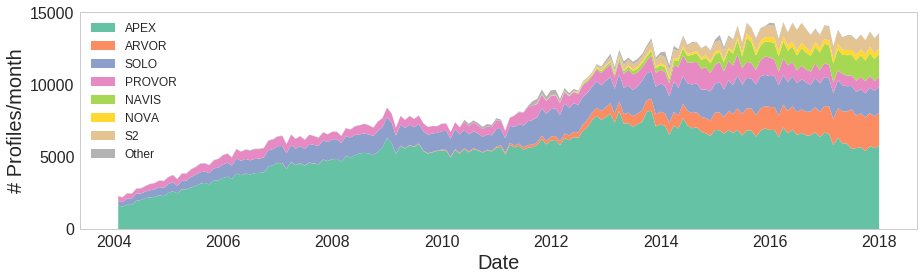

In [87]:
truncTSDF= typeTimeSeriesDf.fillna(0).copy()
tdf = truncTSDF[['date', 'nProf']].copy()
tdf['APEX'] = truncTSDF['APEX'] \
                    + truncTSDF['APEX Profiling Float'] \
                    + truncTSDF['APEX-SBE'] \
                    + truncTSDF['APEX_D']

tdf['ARVOR'] = truncTSDF['ARVOR'] \
                           + truncTSDF['ARVOR_D']
tdf['SOLO'] = truncTSDF['SOLO'] \
                           + truncTSDF['SOLO-W'] \
                           + truncTSDF['SOLO_D'] \
                           + truncTSDF['SOLO_II'] \
                           + truncTSDF['SOLO_W']

tdf['PROVOR'] = truncTSDF['PROVOR'] \
                           + truncTSDF['POPS_PROVOR'] \
                           + truncTSDF['PROVOR-SBE'] \
                           + truncTSDF['PROVOR_CTS3-DO-I'] \
                           + truncTSDF['PROVOR_II'] \
                           + truncTSDF['PROVOR_III'] \
                           + truncTSDF['PROVOR_IV'] \
                           + truncTSDF['PROVOR_MT']

tdf['NAVIS'] = truncTSDF['NAVIS'] \
                           + truncTSDF['NAVISIR'] \
                           + truncTSDF['NAVIS_A']

tdf['NOVA'] = truncTSDF['NOVA'] \
                           + truncTSDF['NOVA-SBE'] \
                           + truncTSDF['Nova-SBE']
                            
tdf['S2'] = truncTSDF['S2A'] \
                  + truncTSDF['S2X']
    
tdf['Other'] =  truncTSDF['Unnamed: 1']\
                +truncTSDF['Usage : ../sh/read_csv_list.sh <']\
                +truncTSDF['Primary sampling: discrete']\
                +truncTSDF['Primary sampling: averaged []']\
                +truncTSDF['HM2000']\
                +truncTSDF['NEMO']\
                +truncTSDF['PALACE']\
                +truncTSDF['ALAMO']\
                +truncTSDF['NINJA'] \
                +truncTSDF['NINJA_D']
                        


truncTSDF.drop(['APEX Profiling Float',
                        'APEX-SBE',
                        'APEX_D', 
                        'ARVOR_D', 
                        'SOLO-W', 
                        'SOLO_W', 
                        'SOLO_D', 
                        'SOLO_II', 
                        'POPS_PROVOR',
                        'PROVOR-SBE',
                        'PROVOR_CTS3-DO-I',
                        'PROVOR_II',
                        'PROVOR_III',
                        'PROVOR_IV',
                        'PROVOR_MT',
                        'S2A',
                        'S2X', 'NOVA-SBE', 'Nova-SBE', 'NAVISIR', 'NAVIS_A', 'NINJA_D'
                        '',
                        'Usage : ../sh/read_csv_list.sh <',
                        'Primary sampling: discrete',
                        'Primary sampling: averaged []'
               ], axis=1, inplace=True)
sns.set_palette(sns.color_palette("Set2", n_colors=8))
truncTSDF.fillna(0, inplace=True)
make_stack_plot(tdf, figsize=(15,4), title=False)
plt.savefig('typeVsTime.eps', dpi=200)
#make_stack_plot(truncTSDF[['date', 'nProf', 'PROVOR', 'SOLO']])
#make_stack_plot(typeTimeSeriesDf)

In [29]:
truncTSDF.columns

Index(['Unnamed: 1', 'ALAMO', 'APEX', 'ARVOR', 'HM2000', 'NAVIS', 'NEMO',
       'NINJA', 'NOVA', 'PALACE', 'PROVOR', 'SOLO', 'date', 'nProf'],
      dtype='object')

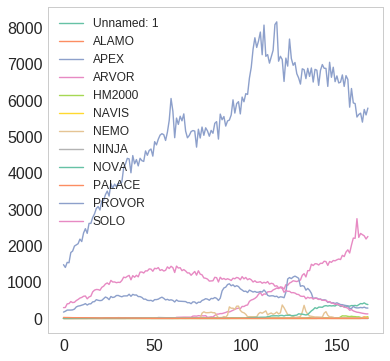

In [30]:
truncTSDF.fillna(0, inplace=True)
truncTSDF.drop(['date', 'nProf'], axis=1).plot()

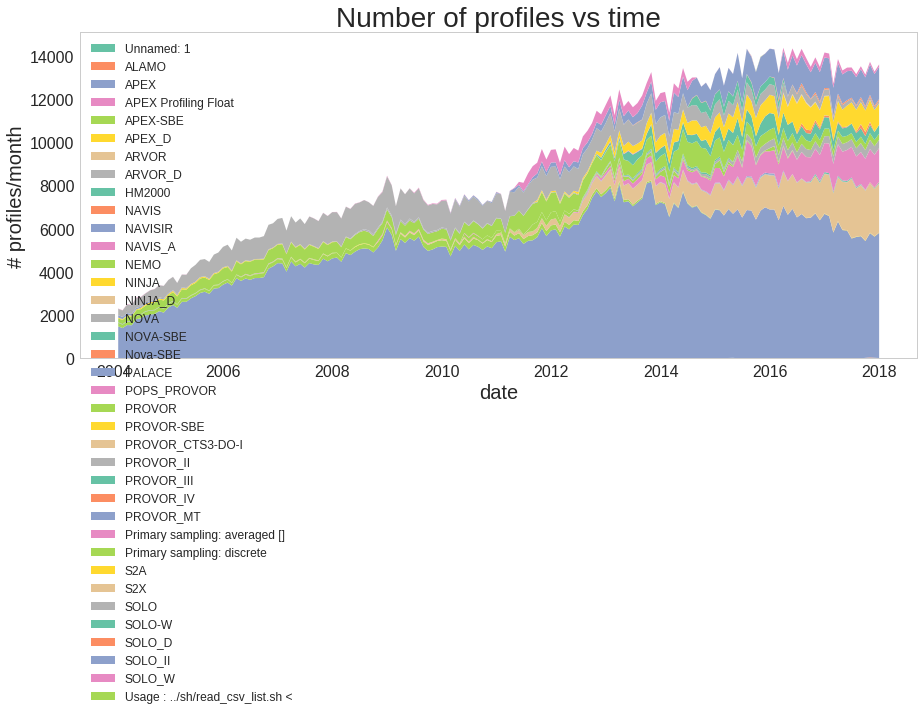

In [31]:
dataDf = typeTimeSeriesDf.drop(['date', 'nProf'], axis=1)
fig = plt.figure(figsize=(15,6))
axes = plt.axes()
axes.set_title('Number of profiles vs time')
axes.set_ylabel('# profiles/month')
axes.set_xlabel('date')
axes.stackplot(typeTimeSeriesDf['date'].values, dataDf.fillna(0).T, labels=dataDf.columns)
axes.legend(loc=2)

In [32]:
dataDf.head()

Unnamed: 1  ALAMO  APEX  APEX Profiling Float  APEX-SBE  APEX_D  ARVOR  \
0         NaN    NaN  1479                   NaN     165.0     NaN    NaN   
1         NaN    NaN  1403                   NaN     158.0     NaN    NaN   
2         NaN    NaN  1542                   NaN     161.0     NaN    NaN   
3         NaN    NaN  1533                   NaN     152.0     NaN    NaN   
4         NaN    NaN  1814                   NaN     164.0     NaN    NaN   

   ARVOR_D  HM2000  NAVIS                ...                 \
0      NaN     NaN    NaN                ...                  
1      NaN     NaN    NaN                ...                  
2      NaN     NaN    NaN                ...                  
3      NaN     NaN    NaN                ...                  
4      NaN     NaN    NaN                ...                  

   Primary sampling: averaged []  Primary sampling: discrete  S2A  S2X  SOLO  \
0                            NaN                         NaN  NaN  NaN   296   
1                            NaN                         NaN  NaN  NaN   300   
2                            NaN                         NaN  NaN  NaN   400   
3                            NaN                         NaN  NaN  NaN   407   
4                            NaN                         NaN  NaN  NaN   463   

   SOLO-W  SOLO_D  SOLO_II  SOLO_W  Usage : ../sh/read_csv_list.sh <  
0     NaN     NaN      NaN    12.0                               NaN  
1     NaN     NaN      NaN    12.0                               NaN  
2     NaN     NaN      NaN    16.0                               NaN  
3     NaN     NaN      NaN    15.0                               NaN  
4     NaN     NaN      NaN    21.0                               NaN  

[5 rows x 37 columns]

In [33]:
psTimeSeriesDf.head()

ARGOS   GPS  GTS  IRIDIUM       date  nProf
0   2899  12.0  NaN      NaN 2004-01-31   3011
1   2792  12.0  NaN      NaN 2004-02-29   2888
2   3116  16.0  NaN      NaN 2004-03-31   3221
3   3077  15.0  NaN      NaN 2004-04-30   3165
4   3461  21.0  NaN      NaN 2004-05-31   3567

In [34]:
sns.set_palette(sns.xkcd_palette(myColors))
psTimeSeriesDf.drop('GTS', axis = 1, inplace=True)
psTimeSeriesDf['GPS'] = psTimeSeriesDf['GPS'] \
                        + psTimeSeriesDf['IRIDIUM']
psTimeSeriesDf.drop('IRIDIUM', axis = 1, inplace=True)

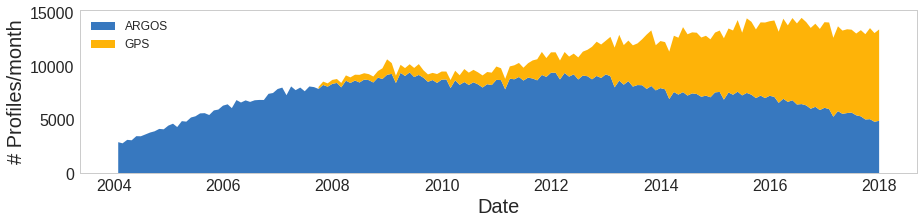

In [58]:
sns.set_palette(sns.xkcd_palette(myColors))
make_stack_plot(psTimeSeriesDf, figsize=(15,4), title=False)
plt.savefig('posSysVsTime.eps', dpi=200)

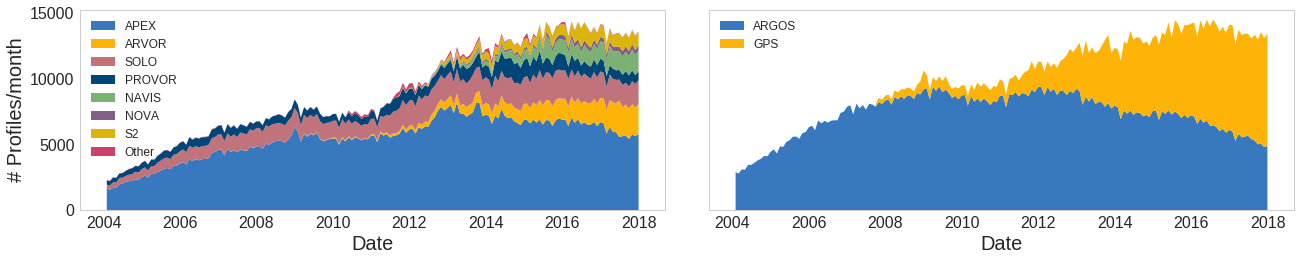

In [131]:
def make_poster_plot(df1, df2, figsize=(18,3.75), title=True):
    dataDf1 = df1.drop(['date', 'nProf'], axis=1)
    dataDf2 = df2.drop(['date', 'nProf'], axis=1)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True)
    plt.tight_layout()
    axes[0].set_ylabel('# Profiles/month')
    axes[0].set_xlabel('Date')
    #sns.set_palette(sns.color_palette("Set2", n_colors=8))
    axes[0].stackplot(df1['date'].values, dataDf1.T, labels=dataDf1.columns)
    axes[0].legend(loc=2)
    #axes[1].set_ylabel('# Profiles/month')
    axes[1].set_xlabel('Date')
    #sns.set_palette(sns.xkcd_palette(myColors))
    axes[1].stackplot(df2['date'].values, dataDf2.T, labels=dataDf2.columns)
    axes[1].legend(loc=2)
    plt.savefig('floatTSHoriz.eps', dpi=200)
sns.set_palette(sns.xkcd_palette(myColors))
make_poster_plot(tdf, psTimeSeriesDf)

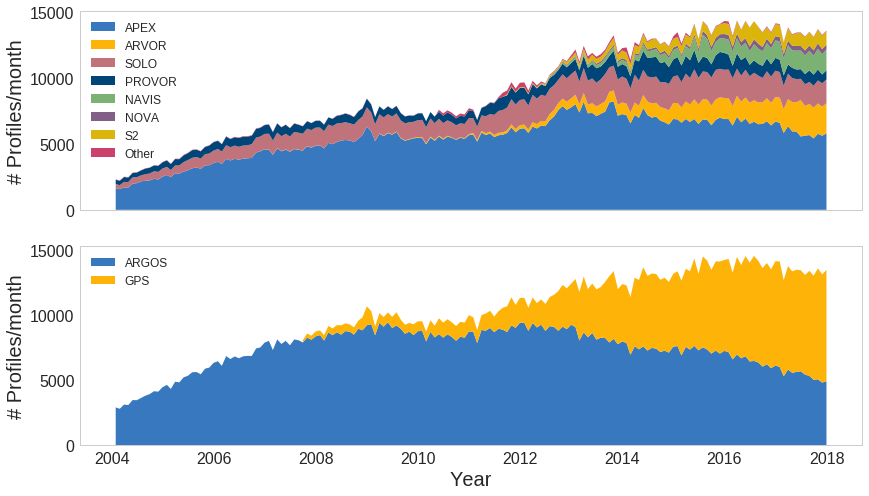

In [189]:
def make_poster_plot2(df1, df2, figsize=(12,7), title=True):
    dataDf1 = df1.drop(['date', 'nProf'], axis=1)
    dataDf2 = df2.drop(['date', 'nProf'], axis=1)
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize, sharex=True)
    plt.tight_layout()
    axes[0].set_ylabel('# Profiles/month')
    #axes[0].set_xlabel('Date')
    #sns.set_palette(sns.color_palette("Set2", n_colors=8))
    axes[0].stackplot(df1['date'].values, dataDf1.T, labels=dataDf1.columns)
    axes[0].legend(loc=2)
    axes[1].set_ylabel('# Profiles/month')
    axes[1].set_xlabel('Year')
    #sns.set_palette(sns.xkcd_palette(myColors))
    axes[1].stackplot(df2['date'].values, dataDf2.T, labels=dataDf2.columns)
    axes[1].legend(loc=2)
    plt.savefig('floatTS.eps', dpi=200, bbox_inches='tight')
make_poster_plot2(tdf, psTimeSeriesDf)

In [ ]:
fig7, axes7 = plt.subplots(nrows=2, ncols=1, sharex=True)

axes7[0].plot(df_ea_and_new.index.values,df_ea_and_new['24km_cov_ea'].values)
axes7[0].plot(df_ea_and_new.index.values,df_ea_and_new['24km_cov'].values)
axes7[0].set_title('Comparison of time series')
axes7[0].set_ylabel('Snow coverage \n $[10^{6} km^{2}]$')
axes7[0].set_ylim([df_ea_and_new['24km_cov_ea'].min(),df_ea_and_new['24km_cov_ea'].max()*1.1])
axes7[0].legend(['assuming grid = 24x24 $km^{2}$','shoe lace method'], loc=2, fontsize = 8)

#need to reset tick lables to match units
tick_labels = map(lambda x: str(x), range(0,8))
axes7[0].set_yticklabels(tick_labels)
right_ax7 = axes7[0].twinx()

right_ax7.set_ylabel('Percent coverage \n [\%]')
right_ax7.set_ylim([0,df_ea_and_new['24km_cov_ea'].max()/tibet_area*100*1.1])
right_ax7.grid(False)

diff = np.subtract(df_ea_and_new['24km_cov_ea'].values, df_ea_and_new['24km_cov'].values)
perc_diff = 100 * np.divide( diff ,df_ea_and_new['24km_cov'].values)
df_ea_and_new['perc_diff'] = perc_diff
#df_ea_and_new['perc_diff'].plot(ax=axes7[1])
axes7[1].plot(df_ea_and_new['perc_diff'].index.values,df_ea_and_new['perc_diff'].values)
axes7[1].set_ylim([df_ea_and_new['perc_diff'].min()*.95,df_ea_and_new['perc_diff'].max()*1.05])
axes7[1].set_title('Percent difference between time series')
axes7[1].set_ylabel('Percent difference \n [\%]')
axes7[1].set_xlabel(r'Year')

In [37]:
psTimeSeriesDf[['ARGOS', 'GPS']].sum()

ARGOS    1227656.0
GPS       455793.0
dtype: float64

In [38]:
psTimeSeriesDf[['ARGOS', 'GPS']].tail(1)

ARGOS     GPS
167   4897  8535.0

# 4. Plotting results

Argovis's plotting capabilities are limited to what is coded in javascript. There are many plotting libraries out there, but in this example we can create plots on our machine, thereby allowing customization.

The method below is used to get color scales from the cmap library, into a matplotlib scale.

In [39]:
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale
thermal_scl = matplotlib_to_plotly(cmocean.cm.thermal, 9)
haline_scl = matplotlib_to_plotly(cmocean.cm.haline, 9)

Argovis uses plotly, which is also available in python. Below the selection data from section 4 are plotted.

In [40]:
tsDf = pd.read_csv('gilbralter.csv')
tsDf = tsDf[['tempMean', 'psalMean', 'tempStd', 'psalStd', 'startDate', 'endDate', 'nProf']]
tsDf['startDate'] = pd.to_datetime(tsDf['startDate'])
tsDf['endDate'] = pd.to_datetime(tsDf['endDate'])

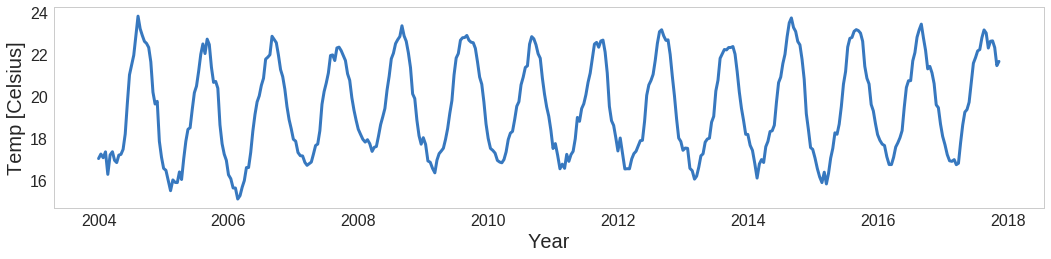

In [191]:
fig = plt.figure(999, figsize=(15,4))
axes = plt.axes()
plt.tight_layout()
temp = tsDf['tempMean'].values
time = tsDf['startDate'].values
axes.plot(time, temp, linewidth=3)
axes.set_ylabel('Temp [Celsius]')
axes.set_xlabel('Year')
plt.tight_layout()
plt.savefig('ts.eps', dpi=300,bbox_inches='tight')

In [53]:
#used for gridding purposes
oceanDf = pd.read_csv('shallow_one_deg_grid.csv')
oceanDf.index=oceanDf.idx
worldGrid = pd.read_csv('worldGridAtOneDeg.csv')
worldGrid.index=worldGrid.idx
oceanGrid = pd.concat([oceanDf[['nProf', 'aggTemp', 'aggPsal']], worldGrid[['lat', 'lon']]], axis=1, join='outer')
oceanGrid.fillna(0, inplace=True)

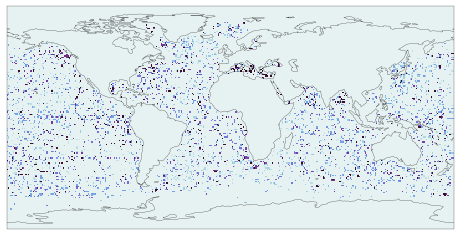

In [54]:
def plot_pmesh(df):
    fig = plt.figure(figsize=(8,12))
    df.sort_values(by=['lon', 'lat'], ascending=[True, False], inplace=True)
    x = df['lon'].values.reshape(180,360)
    y = df['lat'].values.reshape(180,360)
    z = df['nProf'].values.reshape(180,360)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(zorder=1)
    plt.pcolormesh(x, y, z,vmax=40, cmap=cmocean.cm.dense, transform=ccrs.PlateCarree(),zorder=0)
    return fig

df = oceanGrid
pmeshfig = plot_pmesh(df)
plt.show()

# Basemap

I am more familiar with Basemap, but its depreciated. Note that in python3 you will have to troubleshoot. Dispite its flaws, you can create some fantastic projections. Below is a scatter plot of our queried data.

In [55]:
month = 1
year = 2018
monthlyProfilePos = get_monthly_profile_pos(month, year)
monthlyDf = parse_pos_into_df(monthlyProfilePos)
binnedDf = bin_pos_df(monthlyDf, 1)
binnedDf.head()

_id       lat        lon  nProf
latbin lonbin                                         
-15.0  -93.0    3901815_52 -14.90588  -92.72271      1
-33.0  -48.0   5903605_153 -32.30200  -47.91400      4
 2.0    140.0  4901655_128   2.46600  140.68100      2
 17.0  -149.0  4902079_101  17.51000 -148.58600      3
 0.0   -136.0  5904501_207   0.34883 -135.38461      3

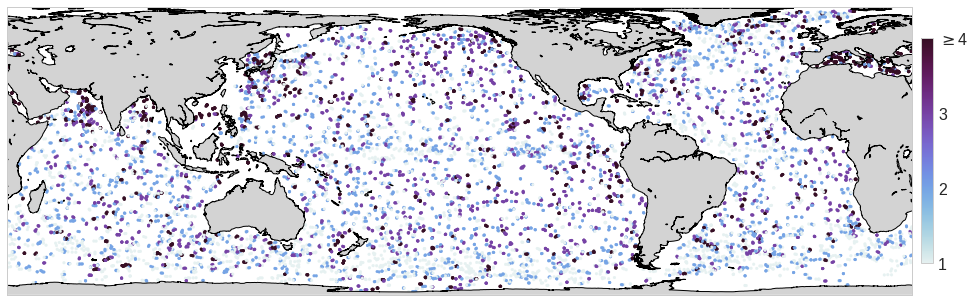

In [181]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_axes([0.001,0.001,0.93,1])
#m = Basemap(projection='cea',llcrnrlat=-90,urcrnrlat=90,\
#            llcrnrlon=-180,urcrnrlon=180,resolution='l')
m = Basemap(projection='cea',lon_0=-145, lat_0 = 50,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='lightgrey')
# draw parallels and meridians.
df = binnedDf

nProf = df.nProf.values
x, y = m(df.lon.values, df.lat.values)
m.scatter(x, y, c=nProf, vmax=4, cmap=cmocean.cm.dense, s=8)
cb = plt.colorbar(location='right', format='%d', fraction=0.012, pad=0.01)
#cb.set_label('# profiles in $1^{\circ}x1^{\circ}$ lat-lon', size=14)
cb.set_ticks([1, 2,3,4])
cb.set_ticklabels(['1',  '2',  '3',  '$\geq$4'])
plt.savefig('worldHist.eps', dpi=400)

Whats nice about using pcolormesh is that you adjust the granularity

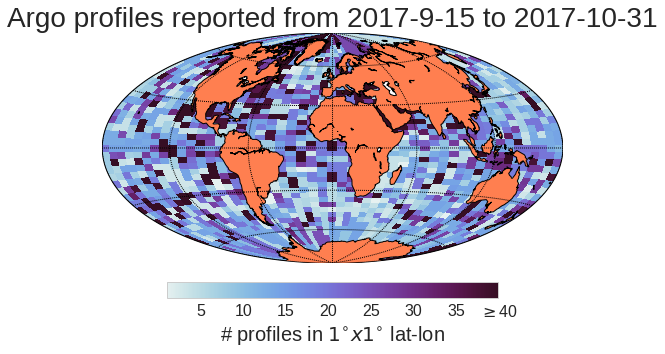

In [68]:
def plot_pcolor_mesh(df, granularity):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    m = Basemap(projection='hammer',lon_0=0, lat_0 = 50, resolution='c')
    m.drawcoastlines()
    m.fillcontinents(color='coral')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,120.,30.))
    m.drawmeridians(np.arange(0.,420.,60.))
    df.sort_values(by=['lon', 'lat'], ascending=[True, False], inplace=True)
    x = df['lon'].values
    y = df['lat'].values
    z = df['nProf'].values
    xx, yy = np.mgrid[-180: 180: granularity, -90: 90: granularity]
    zi = griddata((x, y), z, (xx, yy), method='nearest')
    
    xx, yy = m(xx, yy)
    m.pcolormesh(xx, yy, zi, vmax=40, latlon=False, cmap=cmocean.cm.dense)
    plt.title("Argo profiles reported from {} to {}".format(startDate, endDate))
    cb = plt.colorbar(location='bottom', format='%d', fraction=0.036, pad=0.04, label='# profiles in $1^{\circ}x1^{\circ}$ lat-lon')
    cb.set_ticks([5, 10, 15, 20, 25, 30, 35, 40])
    cb.set_ticklabels(['5', '10', '15', '20', '25', '30', '35', '$\geq$40'])
    return fig

coarse = plot_pcolor_mesh(oceanDf, 50j)

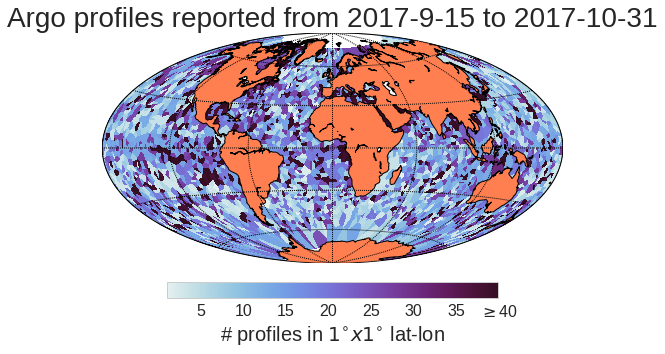

In [69]:
fine = plot_pcolor_mesh(oceanDf, 3000j)